# Sensor Fusion and Rotation Solution

## Introduction

This notebook is intended to keep track of experiments and decisions made regarding sensor fusion with the Dias Geophysical 'bird'.

Note that this document was initially made with LaTeX, which has been included in the directory in which this notebook exists.
This is the more up-to-date version however, so refer to this document when you can.
Code for some of the early images/sections are not available to rerun in this notebook.

## [Versatile Quaternion-based Filter](../Reference_papers/VQF_A_Milestone_in_Accuracy_and_Versatility_of_6D_and_9D_Inertial_Orientation_Estimation.pdf)

Originally proposed by Matt, this paper describes an algorithm for properly calibrating the orientation of devices through inertial orientation esitmation (IOE).
According to the paper, the methodology applied is better than nearly all publicly available algorithms designed for the same purpose.
The authors also make their method available in Python, C++ code and MATLAB

## [Kalman Filters](https://www.kalmanfilter.net/default.aspx)

This is a great site for understanding Kalman filters and how to implement them.

## [Living Document](./Living_Document.pdf) (Dealing with old QAMT code)

Refer to the old 'Living Document' for a mostly rambling accounting of my time spent with the old code.
Towards the end of the document are relevant sections about how the VQF method compares to the results shared by Supracon

## ROS/Gazebo Simulation

Unfortunately, due to the way I am writing this document, a lot of the legwork that went into the creation of these solutions exists in my physical journal and not in this document.

I will digitize that journal for reference so any readers can access it.

In the meantime, this is the fully working version of the ROS/Gazebo simulation as it exists right now:


In [9]:
import math

def euler_from_quaternion(q):
    """
    Convert a quaternion into euler angles (roll, pitch, yaw)
    roll is rotation around x in radians (counterclockwise)
    pitch is rotation around y in radians (counterclockwise)
    yaw is rotation around z in radians (counterclockwise)(this is also heading)

    :param q: Your quaternion, with 4 elements [q0, q1, q2, q3]
    :return:
    """

    w, x, y, z = q
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll_x = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch_y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw_z = math.atan2(t3, t4)

    return roll_x, pitch_y, yaw_z  # in radians

[INFO]  Data folder C:\Users\EthanRunge\Downloads\2023-04-17-16-11-16 already exists. Not creating.


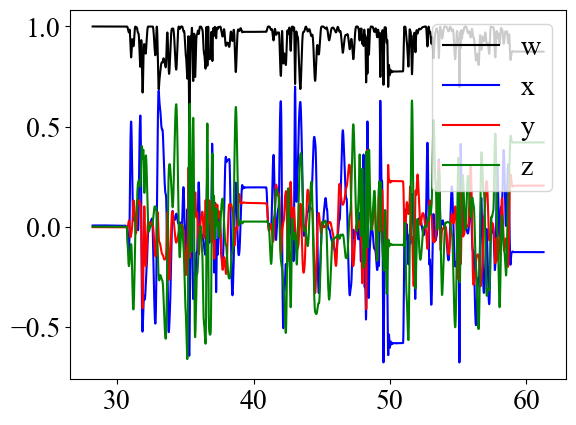

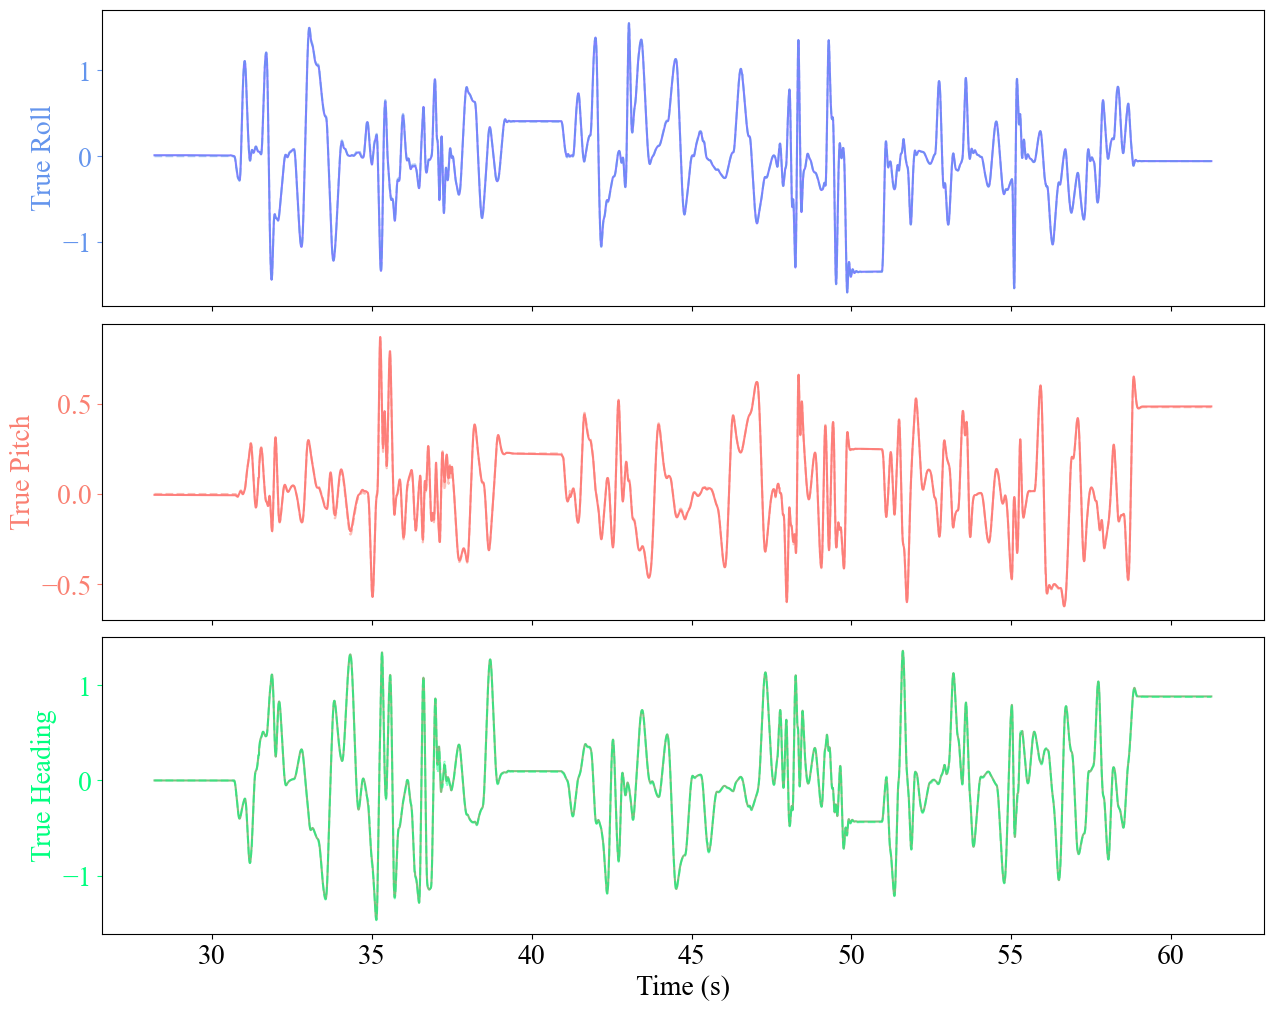

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as scygnal
import matplotlib.colors as mcolors
from vqf import VQF, offlineVQF
import bagpy
import pandas as pd

def compare_simulated(path):
    """
    This function takes as an input a *.bag file that has been generated by a ROS/Gazebo simulated version of the
    instrument. It then applies the VQF methodology to the simulated data and makes a plot of the comparisons between
    the true states used to generate the data and that returned by VQF
    :param path: this is a path to the *.bag file that contains the simulated data
    :return:
    """

    # read in and parse the *.bag file into *.csv
    b = bagpy.bagreader(path)
    joints_csv = b.message_by_topic('/joint_states')
    raw_imu_csv = b.message_by_topic('/raw_imu')
    magnetic_csv = b.message_by_topic('/magnetic')

    # use pandas to read the csv files
    joints = pd.read_csv(joints_csv)
    raw_imu = pd.read_csv(raw_imu_csv)
    magnetic = pd.read_csv(magnetic_csv)

    # pull the required information from the *.csv files (indices can be verified manually by opening *.csv files)
    gyro = np.ascontiguousarray(
        np.array([raw_imu.values[:, 18], raw_imu.values[:, 19], raw_imu.values[:, 20]], dtype='float').T)
    acc = np.ascontiguousarray(
        np.array([raw_imu.values[:, 30], raw_imu.values[:, 31], raw_imu.values[:, 32]], dtype='float').T)
    dt = raw_imu.Time[20] - raw_imu.Time[19]  # choosing a time later in the run, first several points overlap

    vqf = offlineVQF(gyro, acc, None, dt)

    euler_imu = np.array([euler_from_quaternion(vqf['quat6D'][x, :]) for x in range(len(vqf['quat6D']))])

    # plot
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 20

    plt.figure()
    plt.plot(raw_imu.Time, vqf['quat6D'][:, 0], 'k', label='w')
    plt.plot(raw_imu.Time, vqf['quat6D'][:, 1], 'b', label='x')
    plt.plot(raw_imu.Time, vqf['quat6D'][:, 2], 'r', label='y')
    plt.plot(raw_imu.Time, vqf['quat6D'][:, 3], 'g', label='z')
    plt.legend(loc='upper right')

    fig = plt.figure(figsize=(15, 12))
    gs = fig.add_gridspec(9, 9)
    ax1 = fig.add_subplot(gs[:3, :])
    ax2 = fig.add_subplot(gs[3:6, :], sharex=ax1)
    ax3 = fig.add_subplot(gs[6:, :], sharex=ax1)
    # ax4 = ax1.twinx()
    # ax5 = ax2.twinx()
    # ax6 = ax3.twinx()
    ax1.plot(raw_imu.Time, euler_imu[:, 0], 'b', alpha=0.5)
    ax2.plot(raw_imu.Time, euler_imu[:, 1], 'r', alpha=0.5)
    ax3.plot(raw_imu.Time, euler_imu[:, 2], 'g', alpha=0.5)
    # if you want different axes, plot these on ax4, 5, and 6
    ax1.plot(joints.Time, joints.values[:, 11], mcolors.CSS4_COLORS['cornflowerblue'], linestyle='--',
             alpha=0.5)
    ax2.plot(joints.Time, joints.values[:, 10], mcolors.CSS4_COLORS['salmon'], linestyle='--', alpha=0.5)
    ax3.plot(joints.Time, joints.values[:, 9], mcolors.CSS4_COLORS['springgreen'], linestyle='--',
             alpha=0.5)
    ax1.tick_params(axis='y', colors=mcolors.CSS4_COLORS['cornflowerblue'])
    ax1.tick_params(labelbottom=False)
    ax1.set_ylabel('True Roll', color=mcolors.CSS4_COLORS['cornflowerblue'])
    ax2.tick_params(axis='y', colors=mcolors.CSS4_COLORS['salmon'])
    ax2.tick_params(labelbottom=False)
    ax2.set_ylabel('True Pitch', color=mcolors.CSS4_COLORS['salmon'])
    ax3.tick_params(axis='y', colors=mcolors.CSS4_COLORS['springgreen'])
    ax3.set_ylabel('True Heading', color=mcolors.CSS4_COLORS['springgreen'])
    # ax4.tick_params(axis='y', colors='b', right=False)
    # ax4.set_ylabel('Recovered Roll', color='b')
    # ax5.tick_params(axis='y', colors='r', right=False)
    # ax5.set_ylabel('Recovered Pitch', color='r')
    # ax6.tick_params(axis='y', colors='g', right=False)
    # ax6.set_ylabel('Recovered Heading', color='g')
    ax3.set_xlabel('Time (s)')
    
if __name__ == '__main__':
    compare_simulated(r"C:\Users\EthanRunge\Downloads\2023-04-17-16-11-16.bag")

As can be seen here, the true joint positions and those returned by the VQF method are very close.
The difference between our solution and the Supracon solution is still a bit of a mystery in this regard.

## Workflow Enhancement

Once again, due to the way I have been writing this document, a lot of the information behind this section is not/cannot be properly documented.

Cliff notes version, we abandoned `Airborne_DiasPro.py` and created a new workflow that is intended to make use of hdf5 formatted files.
David did a great job on transferring existing functions do the new regime.
I implemented the rotation solution to work within this framework as well, and changed one of the loading functions to make use of numpy, greatly speeding the reading of smartTEM data.
Investigation found that smartTEM was the only loader that still used pure python for loading.

### Procrustes Analysis Enchancement

The Procrustes analysis to get the SQUID data to act as the magnetic data for the heading determination was always a bit fiddly.
As such, I created a little widget to help users select the part of the flight they would like to use for the procrustes analysis.
Code below:

0 0


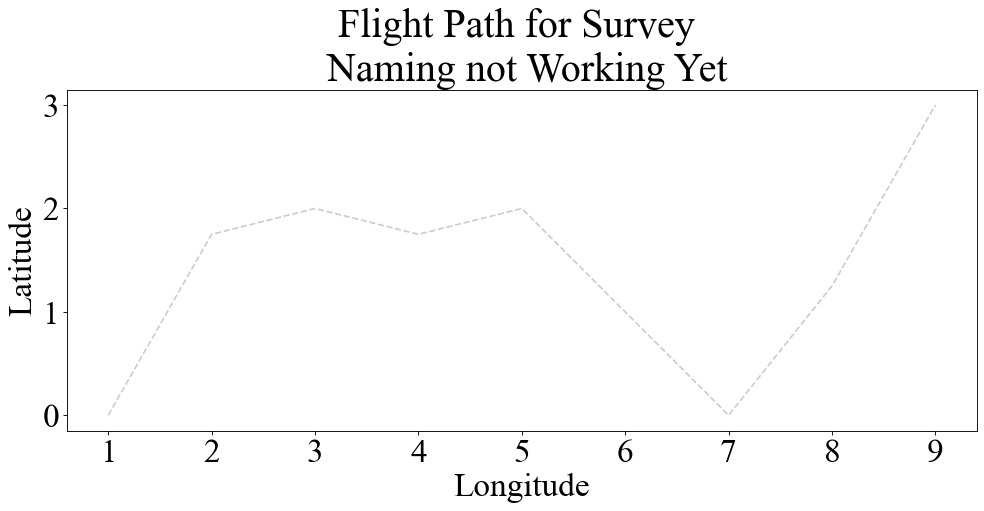

In [15]:
import sys
from PyQt5.QtWidgets import (
    QMainWindow, QApplication,
    QLabel, QCheckBox, QComboBox, QListWidget, QLineEdit,
    QLineEdit, QSpinBox, QDoubleSpinBox, QSlider, QWidget,
    QVBoxLayout, QAction, QPushButton
)
from PyQt5.QtCore import Qt
from PyQt5 import QtGui
import matplotlib.pyplot as plt
from matplotlib.backends.backend_qt5agg import (
    FigureCanvasQTAgg, NavigationToolbar2QT as NavigationToolbar)


class VisualizerApp(QMainWindow):
    def __init__(self, gps_data):
        super(VisualizerApp, self).__init__()

        self.title = "Procrustes Finder"

        self._main = QWidget()
        self.left = 50
        self.top = 90
        self.width = 1400
        self.height = 1000
        self.main_widget = []
        self.identidfied_start = 0
        self.identidfied_end = 0
        self.gps_data = gps_data
        self.init_ui()

    def init_ui(self):
        self.setWindowTitle(self.title)
        self.setWindowIcon(QtGui.QIcon('pythonlogo.png'))
        self.setGeometry(self.left, self.top, self.width, self.height)
        # self.setStyleSheet("background-color: brown;")
        # self.showMaximized()
        self.main_widget = QWidget(self)
        self.main_widget.setGeometry(175, 100, self.frameGeometry().width() - 100 * 2,
                                     self.frameGeometry().height() - 75 * 2)
        self.layout = QVBoxLayout(self.main_widget)
        self.figure = plt.figure(dpi=80)
        self.gs = self.figure.add_gridspec(3, 1)
        self.canvas = FigureCanvasQTAgg(self.figure)
        self.layout.addWidget(self.canvas)
        self.addToolBar(NavigationToolbar(self.canvas, self))
        self.file_name = None

        mainMenu = self.menuBar()

        # exitButton = QAction('Exit', self)
        # exitButton.setShortcut('Ctrl+Q')
        # exitButton.setStatusTip('Exit application')
        # exitButton.triggered.connect(self.close)

        self.clearButton_time = QPushButton('Clear figure', self)
        self.clearButton_time.move(20, 120)
        self.clearButton_time.resize(150, 40)
        self.clearButton_time.clicked.connect(self.clear_figure)

        self.plotButton_time = QPushButton('Update Plot', self)
        self.plotButton_time.move(20, 180)
        self.plotButton_time.resize(150, 40)
        self.plotButton_time.clicked.connect(self.update_plot)

        self.use_index = QPushButton('Use these indices', self)
        self.use_index.move(20, 470)
        self.use_index.resize(150, 60)
        self.use_index.clicked.connect(self.use_indices)

        # related to lower
        self.text1 = QLabel(self)
        self.text1.setText('Procrustes Lower Index')
        self.text1.move(20, 270)
        self.text1.resize(150, 25)

        self.start_slider = QSlider(self)
        self.start_slider.setOrientation(Qt.Horizontal)
        self.start_slider.setRange(0, len(self.gps_data['time'])-1)
        self.start_slider.move(20, 300)
        self.start_slider.resize(150, 30)

        self.textbox = QSpinBox(self)
        self.textbox.setRange(0, len(self.gps_data['time'])-1)
        self.textbox.move(20, 330)
        self.textbox.resize(150, 30)

        self.start_slider.sliderMoved.connect(self.textbox.setValue)
        self.textbox.valueChanged.connect(self.start_slider.setValue)
        self.textbox.valueChanged.connect(self.update_plot)

        # related to upper
        self.text2 = QLabel(self)
        self.text2.setText('Procrustes Higher Index')
        self.text2.move(20, 370)
        self.text2.resize(150, 25)

        self.end_slider = QSlider(self)
        self.end_slider.setOrientation(Qt.Horizontal)
        self.end_slider.setRange(1, len(self.gps_data['time']))
        self.end_slider.move(20, 400)
        self.end_slider.resize(150, 30)

        self.textbox2 = QSpinBox(self)
        self.textbox2.setRange(1, len(self.gps_data['time']))
        self.textbox2.move(20, 430)
        self.textbox2.resize(150, 30)

        self.end_slider.sliderMoved.connect(self.textbox2.setValue)
        self.textbox2.valueChanged.connect(self.end_slider.setValue)
        self.textbox2.valueChanged.connect(self.update_plot)

        self.set_figure()

    def set_figure(self):
        plt.rcParams['font.family'] = 'Times New Roman'
        plt.rcParams['font.size'] = 30
        self.gs = self.figure.add_gridspec(3, 1)
        self.ax1 = self.figure.add_subplot(self.gs[:])
        x = self.gps_data['longitude'][:]
        y = self.gps_data['latitude'][:]
        self.ax1.plot(x, y, 'k--', alpha=0.2)
        self.ax1.set_xlabel('Longitude')
        self.ax1.set_ylabel('Latitude')
        self.ax1.set_title('Flight Path for Survey \n {}'.format('Naming not Working Yet'))
        self.ax1.axis('scaled')
        self.canvas.draw()
        self.x = x
        self.y = y

    def clear_figure(self):
        self.figure.clf()
        self.set_figure()

    def update_plot(self):
        self.figure.clf()
        # This is where the plotting goes
        # temporary plots
        self.set_figure()
        self.ax1.plot(self.x[self.textbox.value():self.textbox2.value()+1],
                      self.y[self.textbox.value():self.textbox2.value()+1],
                      'b', alpha=0.7)
        # ax1.set_xlim([self.textbox.value(), self.textbox2.value()])
        self.canvas.draw()

    def use_indices(self):
        self.identidfied_start = self.textbox.value()
        self.identidfied_end = self.textbox2.value()
        self.close()


if __name__ == '__main__':
    app = QApplication(sys.argv)
    gps_data = dict()
    gps_data['longitude'] = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    gps_data['latitude'] = [0, 1.75, 2, 1.75, 2, 1, 0, 1.25, 3]
    gps_data['time'] = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    w = VisualizerApp(gps_data)
    w.show()
    app.exec()
    identified_start = w.identidfied_start
    identified_end = w.identidfied_end
    print(identified_start, identified_end)


The code will run a basic example to show the user how the function works, and when the user clicks "use these indices" the function exits and prints those indices for the user to see.
This is used in the code to allow the user to pick a region when the rotation option is selected.

## Modifying the workflow

The next major step to work on is the fact that we have some libraries with odd naming convention, with different versions, that need to be used in both MT and QAMT.
The code often breaks because the functions in use are in a library from a different version of the library. 
Example, there is a call to import `spectrum_lib` in nearly all of our python files, but sometimes it is `libraries.spectrum_lib`, `lib.spectrum_lib`, and just `spectrum_lib`.
This would indicate that there are multiple versions of `spectrum_lib` in use in different areas.
What we now want to do is start making a centralized location for these types of files, so modifications need only happen once and to solidify when and where the imports are actually happening.

So, what is in the functions `io_lib`, `io_lib_kalman`, `kalman_lib` and `spectrum_lib` and what is a better way to organize?

### Old Structure

#### `io_lib.py`

This is a function that exists under the "Kalman Filter" folder, relating to the old `Airborne_DiasPro.py` functionality.

It has a `class` for `ProjectParameters` and seems like it is primarily concerned with checking the old `*.inp` files for paths

It appears that this python file has everything related to reading and writing files.
What is the difference between this and `io_lib_kalman.py` then?

As it turns out, there isn't a difference between them.
The only actual usage of `io_lib` in regard to the QAMT processing is the function `read_processing_file` in the processing step "process_tipper_data" or alternatively "process_tipper_data_paralellized".
And this function is no longer in use for the new processing flow.

So nothing needs to be taken over from `io_lib.py`

#### `io_lib_kalman.py`

This set is just a more up-to-date version of `io_lib.py`.
There is no real reason for both to exist in the Kalman Filter related area.

The functions in here are in use heavily throughout the project however.
This file in particular is over 3000 lines long, and has a multitude of classes within it.
Best practice and the way to move forward for now I think is to break this massive library into a series of dedicated classes in their own files, and have them contained under an `io_libs` folder.

#### `kalman_lib.py`

This set of functions was related to the old implementation of the Kalman filter.
The current implementation does not use any of these functions except one reference to `quaternion_to_euler_vectorized` in the function `write_database_rotation_filter` in `qamt_libs.py`.
This function itself is not used in the new workflow however, and the `quaternions_lib.py` has an alternate function that replaces it.

### New Structure

#### `database_io_lib.py`

This is the new set of high level wrapper functions that look for the loading functions.
The current (April 24, 2023) implementation looks for functions in a copied version of `io_lib_kalman.py` to load much of this data by importing the classes.

As such, this is the function that will be most affected by this refactoring.
In fact, no other scripts in the new workflow reference `io_lib_kalman.py` except this function, so changes shouldn't have far reaching consequences.


#### Classes needed from `io_lib_kalman.py`

|Name|Type|Used in New Workflow?|Note|
|-|-|-|-|
|`projectParameters`|Class|No|
|`write_time_segmentation_file`|Function|No||
|`read_time_segmentation_file`|Function|No||
|`fill_input_file`|Function|No||
|`read_input_file`|Function|No||
|`read_scaling_file`|Function|No||
|`read_rotation_file`|Function|No||
|`read_distortion_file`|Function|No||
|`write_raw_input_file`|Function|No||
|`main_filter_parameters_kalman`|Class|No||
|`sub_filter_parameters_kalman`|Class|No||
|`update_log_file`|Function|No||
|`read_main_parameters_file`|No||
|`SmartTEMData`|Class|Yes|This class and the following functions are good candidates for moving to a common library|
|`get_time_smart_tem`|Function|Yes|This function could be bundled into the smartTEM class maybe?|
|`read_smart_tem`|Function|Yes|This function could also be bundled into the class?|
|`ProcessedGPS`|Class|Maybe|This class is called, but is commented out in those cases, with a note about figuring it out in the future. Need to place it in a good place.|
|`create_hdf5_rotation_parameters`|Function|No||
|`add_hdf5_innovation`|Function|No||
|`add_hdf5_rotation_parameters`|Function|No|Has a commented out version that appears to be vectorized|
|`reverse_hdf5`|Function|No||
|`flush_hdf5`|Function|No||
|`write_sicmag_hdf5`|Function|No||
|`write_database_rotation_filter`|Function|No||
|`write_database_kalman_filter`|Function|No||
|`write_database_processing`|Function|No||
|`add_hdf5_rotation_parameters`|Function|No|This one is commented out, a repeat of earlier function with some differences|
|`create_hdf5_processed_file_QMAG`|Function|No||
|`get_sicmag_lines`|Function|No||
|`xsense_uimu`|Class|No|This should be kept and moved into the `io_libs` in case this IMU is used again.|
|`fogIMU`|Class|No|This is the built-in IMU, creates `*.gyro` files, we need to keep this.|
|`uimu`|Class|Yes|This is our primary IMU, creates `*.uimu` files, keep this.|
|`Gps`|Class|Yes|This needs to be kept for sure as well. Reads our `*.gps` files.|
|`Adc`|Class|Yes*|This is the class that reads the `*.adc` files created by the fluxgate on flights that have it, we need to keep it and find a way to change the workflow to incorporate it when we have proper data.|
|`sicmag`|Class|No|We have new functions in use that replace this.|
|`hex_date_to_utc_array`|Function|Yes|Has decorator: `@guvectorize(['void(uint8[:,:], int16[:], int64[:])'], '(m, n)->(m),(m)', target='cpu')`|
|`recompose_sicmag`|Function|No|Used only in `struct_sicmag`, which has been deprecated|
|`big_endian_6_bits`|Function|No||
|`struct_uimu`|Function|No|Should probably keep for the sake of completeness? It's been superceded by a "v2". More importantly, this seems like the type of thing that should be kept in the uimu class. This is likely what will happen.|
|`struct_uimu_v2`|Function|Yes|This is used, but it should be part of the uimu class. Rework needed.|
|`gps_from_minutes_to_decimal`|Function|Yes|Used in `get_gps_from_gps_string`|
|`get_gps_from_gps_string`|Function|Yes|Used in `read_GPS`|
|`read_GPS`|Function|Yes|Used in `Class Gps`, within the load function. The current connections are confusing, refactor|
|`struct_adc`|Function|Yes*|Used in the `Class Adc`, so is necessary. However, it should be part of that class.|
|`struct_sicmag`|Function|No|Superceded by `struct_sicmag_v2`|
|`read_radar_alt`|Function|No||
|`read_laser_alt`|Function|No||
|`get_uimu_size`|Function|Yes|Used in `Class uimu`, should be part of class|
|`get_sicmag_size_deprecated`|Function|No||
|`get_adc_size`|Function|Yes|Used in `Class Adc`, should be part of class|
|`read_matlab_file`|Function|No||
|`read_gpx`|Function|Yes|Used in `read_gpx_endlines` function in new workflow|
|`organizeLines`|Function|Yes|Used in `read_gpx_endlines` function in new workflow|
|`write_rotation_file`|Function|No||
|`write_distortion_file`|Function|No||
|`write_scaling_file`|Function|No||
|`write_rotation_file_oneScale`|Function|No||
|`get_beginning_file`|Function|Yes|Used in `Class sicmag` (deprecated) and in `read_qamt_files`. Move to a location that has all of these files together.|
|`recompose_sicmag`|Function|No|Used in `struct_sicmag` (deprecated), second time defined, but has `@guvectorize` on it in this instance.|
|`recompose_sicmag_v2`|Function|No||
|`recompose_sicmag_v3`|Function|No||
|`get_sicmag_size_v2`|Function|No|Used in `Class sicmag` (deprecated), function also deprecated and has a replacement.|
|`get_sicmag_size`|Function|Yes|This is the most up-to-date version of the sicmag size determination, should be in a library, perhaps as part of a class.|
|`read_reformat_sicmag_data`|Function|Yes|This is the most up-to-date version of the sicmag reader, should be in a library or part of a class.|
|`struct_sicmag_v2`|Function|No|Deprecated, used in `Class sicmag`.|
|`get_gyro_size`|Function|Yes|Need to have this ready to read `*.gyro` files, part of `Class fogIMU`.|
|`struct_gyro`|Function|Yes|Needs to be ready, `*.gyro`, `Class fogIMU`.|

That was a lot.
Most of it is redundant and unused.

#### What the Structure Needs to Look Like

* Smart TEM library
* GPS related - gps and gpx
* IMU related class(es) - fogIMU and uIMU
* ADC/fluxgate related
* QAMT database

Have it set up so that `database_io_lib.py` looks into these folders for ALL necessary functions.

The PR has been pushed.

## Consistency and Usability

Next step is to make everything consistent for the user.
~First up, make everything use `plotly`~. 
Nevermind, this doesn't work particularly well.
`plotly` is good for data analysis after the fact, not good for choosing data points.
Then, I will probably want to make the procrustes chooser more like David's line choice UI.


## Moving the Libraries

We also want to make a common library, with tests, for MT processing that are common to both MT and QAMT.
